In [24]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
import matplotlib as mpl
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl

import lmfit
# from lmfit.models import SkewedGaussianModel, SkewedVoigtModel
from lmfit.lineshapes import gaussian2d, lorentzian

from astropy.modeling import models, fitting

import scipy.stats as stats
import scipy.optimize as opt
from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
import cage_utils
# plt.rcParams['figure.figsize'] = [14, 10]
plt.style.use('./joule_dissertation.mplstyle')

In [2]:
run = 60 #44 #70 #64
dsp_id = '02'
user = True
hit =True
cal = True
lowE=False
etype = 'trapEftp_cal'

corr_DCR=True
corr_AoE=True
corr_ToE=True

norm = True
cut = True


dsp_list = ['energy', 'trapEftp', 'trapEmax', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'AoE', 'dcr', "tp_0", "tp_02", "tp_05", "tp_10", "tp_20", "tp_30", "tp_40", "tp_50", "tp_60", "tp_70", "tp_80", "tp_90", "tp_96", 'tp_max', 'ToE', 'log_tail_fit_slope', 'wf_max', 'wf_argmax', 'trapE_argmax', 'lf_max']

df_raw, dg, runtype, rt_min, radius, angle_det, rotary = cage_utils.getDataFrame(run, user=user, hit=hit, cal=cal, dsp_list=dsp_list, lowE=lowE)

df = cage_utils.apply_DC_Cuts(run, df_raw)

# df_60 = df.query('trapEftp_cal > 55 and trapEftp_cal < 65').copy()
# df_60 = df.query('trapEftp_cal > 55 and trapEftp_cal < 80').copy()


Radius: 2.5; Angle: 90; Rotary: 0.0
user: True; cal: True; hit: True
Using hit files
loading data for /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc840_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc841_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc842_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc843_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc844_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc845_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc846_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc847_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc848_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run60_cyc849_hit.lh5
No options specified for cut selection! Using de

In [3]:
with open('./analysis_60keV.json') as f:
        params = json.load(f)

In [4]:
mean_60 = params[str(run)]['mean_60']
sig_60 = params[str(run)]['sig_60']
chiSquare_fit_60 = params[str(run)]['chiSquare_fit_60']
cut_60_3sig = params[str(run)]['cut_60_3sig']
bkg_60_left = params[str(run)]['bkg_60_left']
bkg_60_right = params[str(run)]['bkg_60_right']
bkg_60 = params[str(run)]['bkg_60']

In [5]:

# cut_60_3sig = f'({mean_60-3*sig_60} <= trapEftp_cal <= {mean_60+3*sig_60})'
# cut_60_left = f'({mean_60-3*sig_60} <= trapEftp_cal < {mean_60})'
# cut_60_right = f'({mean_60} <= trapEftp_cal < {mean_60+3*sig_60})'


# bkg_60_left_min = mean_60-7.*sig_60
# bkg_60_left_max = mean_60-4*sig_60

# bkg_60_right_min = mean_60+4*sig_60
# bkg_60_right_max = mean_60+7.*sig_60

# bkg_60_left = f'({mean_60-7.*sig_60} <= trapEftp_cal < {mean_60-4*sig_60})'
# bkg_60_right = f'({mean_60+4*sig_60} < trapEftp_cal <= {mean_60+7.*sig_60})'


counts_peak = len(df.query(cut_60_3sig).copy())
err_peak = np.sqrt(counts_peak)

# left_counts = len(df.query(bkg_60_left))
# right_counts = len(df.query(bkg_60_right))

total_bkg = len(df.query(bkg_60).copy())
err_bkg = np.sqrt(total_bkg)


counts = counts_peak - total_bkg
err = np.sqrt(counts_peak + total_bkg)
print(f'bkg_subtracted counts: {counts}')
print(f'error: {err}')
print(f'{(err/counts)*100:.3f}%')


bkg_subtracted counts: 3752
error: 131.52186130069785
3.505%


In [6]:
(counts + total_bkg)/counts_peak

1.0

In [7]:
df_60 = df.query(cut_60_3sig).copy()
df_bkg = df.query(bkg_60).copy()

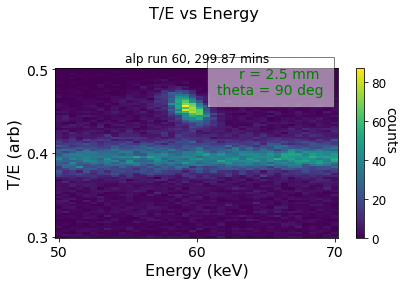

In [8]:
fig, ax = plt.subplots()
elo, ehi, epb = 50, 70, 0.5
ToElo, ToEhi, ToEpb= 0.3,  0.5, 0.0025

nbx = int((ehi-elo)/epb)
nby = int((ToEhi-ToElo)/ToEpb)



fig.suptitle(f'T/E vs Energy', horizontalalignment='center', fontsize=16)

ToE_hist_norm, xedges, yedges = np.histogram2d(df['trapEftp_cal'], df['ToE'], bins=[nbx, nby], range=([elo, ehi], [ToElo, ToEhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, ToElo:ToEhi:nby*1j]


pcm = plt.pcolormesh(X, Y, ToE_hist_norm,  shading='nearest') #0.002, 0.2

cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel(f'Energy (keV)', fontsize=16)
ax.set_ylabel('T/E (arb)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)


ax.text(0.95, 0.83, f'r = {radius} mm \ntheta = {angle_det} deg', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# plt.legend()
plt.title(f'\n{runtype} run {run}, {rt_min:.2f} mins', fontsize=12)
plt.tight_layout()
# plt.ylim(-0.05, 0.1)
# plt.ylim(-0.05, 0.08)
# plt.ylim(0.42, 0.51)
# plt.xlim(52.5, 65)
plt.show()

80


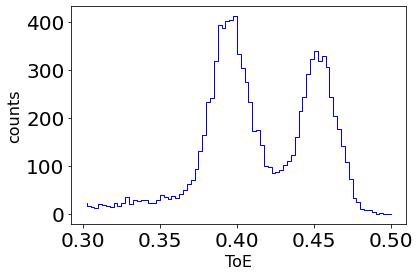

In [9]:
ToElo, ToEhi, ToEpb= 0.3,  0.5, 0.0025
nbx = int((ToEhi-ToElo)/ToEpb)

print(nbx)

# bl_sig_lo, bl_sig_hi = 3.1, 5. # run 70
# bl_sig_lo, bl_sig_hi = 3.1, 5.25
# bl_sig_lo_raw, bl_sig_hi_raw = quant_raw_sig[0], quant_raw_sig[1]  

ToE_full_hist, bins = np.histogram(df_60['ToE'], bins=nbx,
                range=[ToElo, ToEhi])

plt.plot(bins[1:], ToE_full_hist, ds='steps', c='b', lw=1)


# plt.axvline(bl_sig_lo_raw, c='r', lw=1)
# plt.axvline(bl_sig_hi_raw, c='r', lw=1)

plt.xlabel('ToE', fontsize=16)
plt.ylabel('counts', fontsize=16)

# plt.xlim(0.35, 0.5)
plt.show()

80


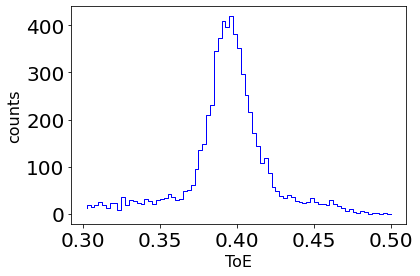

In [10]:
ToElo, ToEhi, ToEpb= 0.3,  0.5, 0.0025
nbx = int((ToEhi-ToElo)/ToEpb)

print(nbx)

# bl_sig_lo, bl_sig_hi = 3.1, 5. # run 70
# bl_sig_lo, bl_sig_hi = 3.1, 5.25
# bl_sig_lo_raw, bl_sig_hi_raw = quant_raw_sig[0], quant_raw_sig[1]  

ToE_bkg_hist, bins = np.histogram(df_bkg['ToE'], bins=nbx,
                range=[ToElo, ToEhi])

plt.plot(bins[1:], ToE_bkg_hist, ds='steps', c='b', lw=1)


# plt.axvline(bl_sig_lo_raw, c='r', lw=1)
# plt.axvline(bl_sig_hi_raw, c='r', lw=1)

plt.xlabel('ToE', fontsize=16)
plt.ylabel('counts', fontsize=16)

# plt.xlim(0.35, 0.5)
plt.show()

In [11]:
ToE_60_hist = ToE_full_hist - ToE_bkg_hist

80


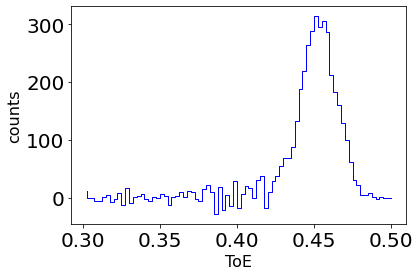

In [12]:
ToElo, ToEhi, ToEpb= 0.3,  0.5, 0.0025
nbx = int((ToEhi-ToElo)/ToEpb)

print(nbx)

# bl_sig_lo, bl_sig_hi = 3.1, 5. # run 70
# bl_sig_lo, bl_sig_hi = 3.1, 5.25
# bl_sig_lo_raw, bl_sig_hi_raw = quant_raw_sig[0], quant_raw_sig[1]  

plt.plot(bins[1:], ToE_60_hist, ds='steps', c='b', lw=1)


# plt.axvline(bl_sig_lo_raw, c='r', lw=1)
# plt.axvline(bl_sig_hi_raw, c='r', lw=1)

plt.xlabel('ToE', fontsize=16)
plt.ylabel('counts', fontsize=16)

# plt.xlim(0.35, 0.5)
plt.show()

In [14]:
times_2, all_60_taligned = cage_utils.get_superpulse_taligned(df, dg, cut_60_3sig, all=True, norm=False, tp_align=0.5, n_pre = 3800, n_post = 4000)

using all 10525 Waveforms passing cut


In [ ]:
times_2, all_60_taligned = cage_utils.get_superpulse_taligned(df, dg, cut_60_3sig, all=True, norm=False)

In [ ]:
times_2, all_60_taligned = cage_utils.get_superpulse_taligned(df, dg, cut_60_3sig, nwfs = 10, norm=False)

In [15]:
# times, all_60 = cage_utils.get_superpulse(df, dg, cut_60_3sig, all=True, norm=False)
times, all_60 = cage_utils.get_superpulse_taligned(df, dg, cut_60_3sig, all=True, norm=False)

using all 10525 Waveforms passing cut


In [16]:
times, bkg_60 = cage_utils.get_superpulse_taligned(df, dg, bkg_60, all=True, norm=False)

using all 6773 Waveforms passing cut


In [17]:
bkg_sub_60 = (counts_peak/counts)*(all_60 - (total_bkg/counts_peak)*bkg_60)
# bkg_sub_60 = (all_60 - bkg_60)

# bkg_sub_60 = 2*all_60 - bkg_60
# bkg_sub_60_2a = all_60 - bkg_60
# bkg_sub_60_2 = np.divide(bkg_sub_60_2a, np.amax(bkg_sub_60_2a))
# bkg_sub_diff = bkg_sub_60_2 - bkg_sub_60

In [ ]:
print(len(times_2))
print(len(all_60_taligned))

In [ ]:
fig, ax = plt.subplots()
# plt.plot(times[:-1], all_60[:-1], '-b', label=('All 60 keV'))
plt.plot(times_2, all_60_taligned, '-g', label=('All 60 keV\time-aligned'))




# plt.xlim(0, 200)
# plt.ylim(-2.5, 2.5)


plt.xlim(3600, 4000)
# plt.ylim(-0.025, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


# plt.xlim(3800, 8000)
# plt.ylim(0.75, 1)

# plt.xlim(3800, 4300)
# plt.ylim(0.95, 1)

# plt.xlim(3900, 4100)
# plt.ylim(-0.025, 0.2)


plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('normalized', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'run {run}; {radius} mm', fontsize = 16)
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontw

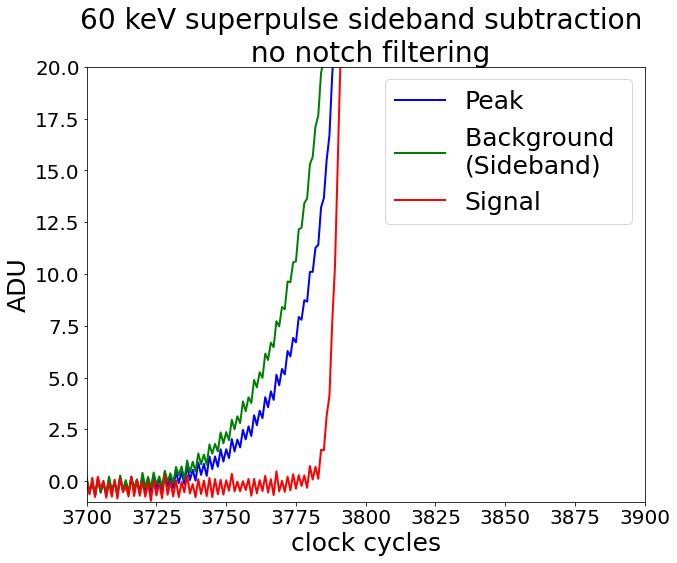

In [44]:
fig, ax = plt.subplots()
plt.plot(times[:-1], all_60[:-1], '-b', lw=2, label=('Peak'))
plt.plot(times[:-1], bkg_60[:-1], '-g', lw=2, label=('Background \n(Sideband)'))
plt.plot(times[:-1], bkg_sub_60[:-1], '-r', lw=2, label=('Signal'))


plt.xlim(3700, 3900)
plt.ylim(-1, 20)


plt.setp(ax.get_xticklabels())
plt.setp(ax.get_yticklabels())

plt.xlabel('clock cycles')
plt.ylabel('ADU')

plt.legend()

plt.title(f'60 keV superpulse sideband subtraction \n no notch filtering') #run {run}; {radius} mm
plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulses_bkgSub_demo_rise_noNotch.png', dpi=200)
plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulses_bkgSub_demo_rise_noNotch.pdf', dpi=200)

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontw

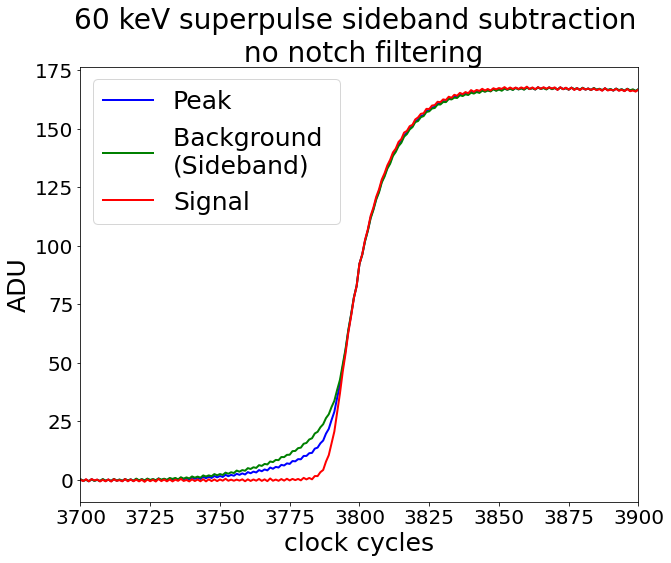

In [45]:
fig, ax = plt.subplots()
plt.plot(times[:-1], all_60[:-1], '-b', lw=2, label=('Peak'))
plt.plot(times[:-1], bkg_60[:-1], '-g', lw=2, label=('Background \n(Sideband)'))
plt.plot(times[:-1], bkg_sub_60[:-1], '-r', lw=2, label=('Signal'))

plt.xlim(3700, 3900)


plt.setp(ax.get_xticklabels())
plt.setp(ax.get_yticklabels())

plt.xlabel('clock cycles')
plt.ylabel('ADU')

plt.legend()

plt.title(f'60 keV superpulse sideband subtraction \n no notch filtering') #run {run}; {radius} mm
plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulses_bkgSub_demo_riseTail_noNotch.png', dpi=200)
plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulses_bkgSub_demo_riseTail_noNotch.pdf', dpi=200)

In [19]:
all_60_norm =  np.divide(all_60, np.amax(all_60))
bkg_60_norm =  np.divide(bkg_60, np.amax(bkg_60))
bkg_sub_60_norm =  np.divide(bkg_sub_60, np.amax(bkg_sub_60))

all_60_norm_notched =  cage_utils.notchFilter_SIS3302(all_60_norm, Q=20)
bkg_60_norm_notched =  cage_utils.notchFilter_SIS3302(bkg_60_norm, Q=20)
bkg_sub_60_norm_notched =  cage_utils.notchFilter_SIS3302(bkg_sub_60_norm, Q=20)

all_60_notched =  cage_utils.notchFilter_SIS3302(all_60, Q=20)
bkg_60_notched =  cage_utils.notchFilter_SIS3302(bkg_60, Q=20)
bkg_sub_60_notched =  cage_utils.notchFilter_SIS3302(bkg_sub_60, Q=20)

all_60_notched_norm =  np.divide(all_60_notched, np.amax(all_60_notched))
bkg_60_notched_norm =  np.divide(bkg_60_notched, np.amax(bkg_60_notched))
bkg_sub_60_notched_norm =  np.divide(bkg_sub_60_notched, np.amax(bkg_sub_60_notched))

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontw

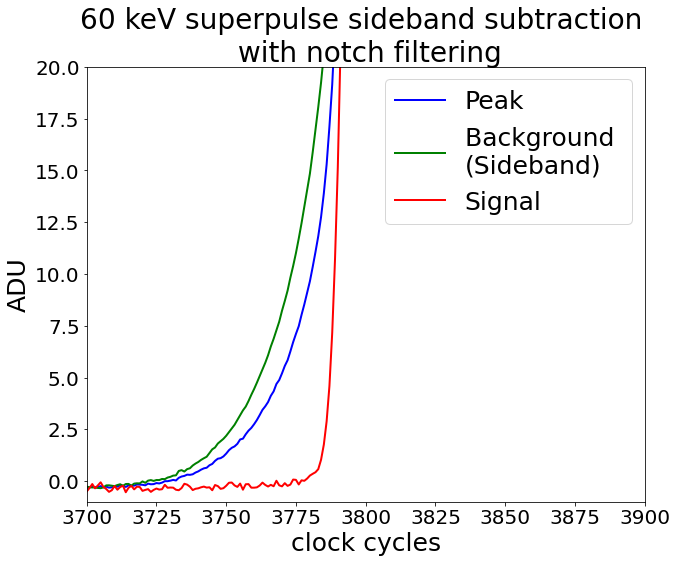

In [47]:
fig, ax = plt.subplots()
plt.plot(times[:-1], all_60_notched[:-1], '-b', lw=2, label=('Peak'))
plt.plot(times[:-1], bkg_60_notched[:-1], '-g', lw=2, label=('Background \n(Sideband)'))
plt.plot(times[:-1], bkg_sub_60_notched[:-1], '-r', lw=2, label=('Signal'))


plt.xlim(3700, 3900)
plt.ylim(-1, 20)


plt.setp(ax.get_xticklabels())
plt.setp(ax.get_yticklabels())

plt.xlabel('clock cycles')
plt.ylabel('ADU')

plt.legend()

plt.title(f'60 keV superpulse sideband subtraction \n with notch filtering') #run {run}; {radius} mm
plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulses_bkgSub_demo_rise.png', dpi=200)
plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulses_bkgSub_demo_rise.pdf', dpi=200)

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontw

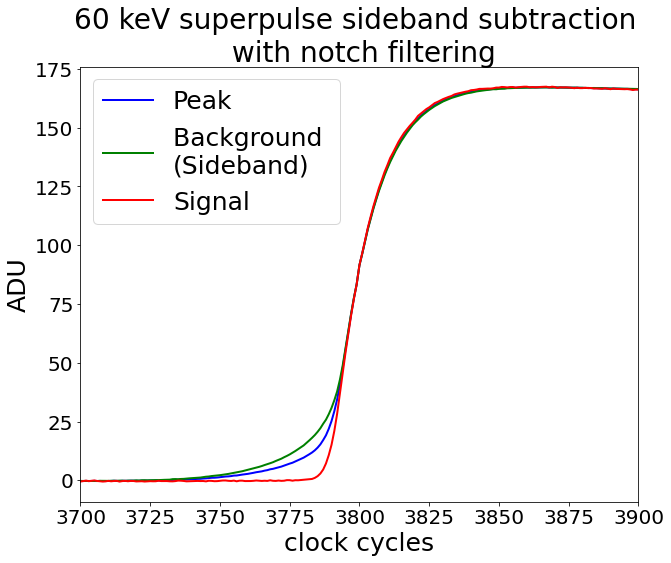

In [48]:
fig, ax = plt.subplots()
plt.plot(times[:-1], all_60_notched[:-1], '-b', lw=2, label=('Peak'))
plt.plot(times[:-1], bkg_60_notched[:-1], '-g', lw=2, label=('Background \n(Sideband)'))
plt.plot(times[:-1], bkg_sub_60_notched[:-1], '-r', lw=2, label=('Signal'))

plt.xlim(3700, 3900)


plt.setp(ax.get_xticklabels())
plt.setp(ax.get_yticklabels())

plt.xlabel('clock cycles')
plt.ylabel('ADU')

plt.legend()

plt.title(f'60 keV superpulse sideband subtraction \n with notch filtering') #run {run}; {radius} mm
plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulses_bkgSub_demo_riseTail.png', dpi=200)
plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/superpulses_bkgSub_demo_riseTail.pdf', dpi=200)

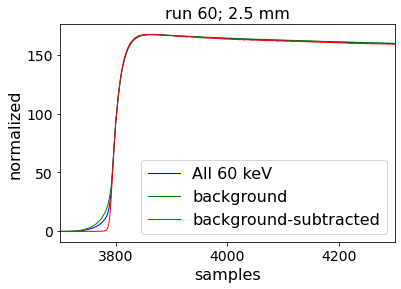

In [20]:
fig, ax = plt.subplots()
plt.plot(times[:-1], all_60_notched[:-1], '-b', label=('All 60 keV'))
plt.plot(times[:-1], bkg_60_notched[:-1], '-g', label=('background'))
plt.plot(times[:-1], bkg_sub_60_notched[:-1], '-r', label=('background-subtracted'))




# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

plt.xlim(3700, 4300)
# plt.ylim(-0.025, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


# plt.xlim(3800, 8000)
# plt.ylim(125, 175)
# plt.ylim(0.75, 1)

# plt.xlim(3800, 4300)
# plt.ylim(0.95, 1)

# plt.xlim(3900, 4100)
# plt.ylim(-0.025, 0.2)


plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('normalized', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'run {run}; {radius} mm', fontsize = 16)
plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.plot(times[:8000], all_60_notched_norm[:8000], '-b', label=('All 60 keV'))
plt.plot(times[:8000], bkg_60_notched_norm[:8000], '-g', label=('background'))
plt.plot(times[:8000], bkg_sub_60_notched_norm[:8000], '-r', label=('background-subtracted'))




# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

# plt.xlim(3700, 4300)
# plt.ylim(-0.025, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


plt.xlim(3800, 8000)
plt.ylim(0.75, 1.005)

# plt.xlim(3800, 4300)
# plt.ylim(0.95, 1.001)

# plt.xlim(3900, 4100)
# plt.ylim(-0.025, 0.2)


plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('normalized', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'run {run}; {radius} mm \nnormal incidence', fontsize = 16)
# plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/run{run}_wf_bkg_sub.png', dpi=200)
plt.savefig(f'./plots/new_normScan/60keV_analysis/waveforms/run{run}_wf_bkg_sub_tail.png', dpi=200)
plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.plot(times[:-1], bkg_sub_60_notched_norm[:-1], '-g', label=('normed after notch'))
plt.plot(times[:-1], bkg_sub_60_norm_notched[:-1], '-r', label=('normed before notch'))




# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

plt.xlim(3700, 4300)
# plt.ylim(-0.025, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


plt.xlim(3800, 8000)
# plt.ylim(125, 175)
plt.ylim(0.75, 1)

# plt.xlim(3800, 4300)
# plt.ylim(0.95, 1)

# plt.xlim(3900, 4100)
# plt.ylim(-0.025, 0.2)


plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('normalized', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'run {run}; {radius} mm', fontsize = 16)
plt.show()

In [ ]:
new_60 = np.divide(bkg_sub_60_notched, np.amax(bkg_sub_60_notched))

In [ ]:
f_superpulse = './data/normScan/run60_superpulses.hdf5'
# f_superpulse = './data/normScan/run60_superpulses.hdf5'

data_superpulse = pd.read_hdf(f_superpulse, key = '/superpulses')
orig_60 = data_superpulse['pure_60'][0]
raw_superpulse_60 = data_superpulse['pure_60_raw'][0]
raw_superpulse_60_norm = np.divide(raw_superpulse_60, np.amax(raw_superpulse_60))
raw_superpulse_60_notched = cage_utils.notchFilter_SIS3302(raw_superpulse_60, Q=20)
# orig_60 = raw_superpulse_60_notched

In [ ]:
fig, ax = plt.subplots()
plt.plot(times[:-1], bkg_sub_60_notched[:-1], '-b', label=('sideband subtracted'))
plt.plot(times[:-1], raw_superpulse_60_notched[:-1], '-g', label=('ToE cut'))
# plt.plot(times[:-1], bkg_sub_60_norm_notched[:-1], '-r', label=(''))



# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

# plt.xlim(3700, 4300)
# plt.ylim(-0.025, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


# plt.xlim(3800, 8000)
# plt.ylim(0.75, 1)

# plt.xlim(3800, 4300)
# plt.ylim(125, 175)

plt.xlim(3800, 8000)
plt.ylim(125, 175)

# plt.xlim(3900, 4100)
# plt.ylim(-0.025, 0.2)

# plt.xlim(4500, 6000)
# plt.ylim(0.85, 0.95)


plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('normalized', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'Normed after notch filter', fontsize = 16)
plt.show()

In [ ]:
res = (bkg_sub_60_notched - raw_superpulse_60_notched)/np.amax(raw_superpulse_60_notched)

fig, ax = plt.subplots()
plt.plot(res)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.axhline(y=0)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('difference', fontsize = 16)
plt.title(f'Not normalized', fontsize = 16)
# plt.xlim(3700, 4300)

In [ ]:
fig, ax = plt.subplots()
plt.plot(times[:-1], new_60 [:-1], '-b', label=('sideband subtracted'))
plt.plot(times[:-1], orig_60[:-1], '-g', label=('ToE cut'))
plt.plot(times[:-1], bkg_60_notched_norm[:-1], '-r', label=('bkg'))



# plt.xlim(0, 4300)
# plt.ylim(-0.025, 0.1)

# plt.xlim(3700, 4300)
# plt.ylim(-0.025, 0.2)

# plt.xlim(3700, 3710)
# plt.ylim(-0.025, 0.1)


# plt.xlim(3800, 8000)
# plt.ylim(0.75, 1)

plt.xlim(3800, 4300)
plt.ylim(0.95, 1.001)

# plt.xlim(3900, 4100)
# plt.ylim(-0.025, 0.2)

# plt.xlim(4500, 6000)
# plt.ylim(0.85, 0.95)


plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('normalized', fontsize=16)

plt.legend(fontsize=16)

plt.title(f'Normed after notch filter', fontsize = 16)
plt.show()

In [ ]:
res = (new_60 - orig_60)

fig, ax = plt.subplots()
plt.plot(res)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.axhline(y=0)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('difference', fontsize = 16)
plt.title(f'Normed after notch filter', fontsize = 16)
# plt.xlim(3700, 4300)

In [ ]:
bkg_comp = (bkg_60_notched_norm - orig_60)

fig, ax = plt.subplots()
plt.plot(bkg_comp)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.axhline(y=0)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('difference', fontsize = 16)
plt.title(f'Normed after notch filter', fontsize = 16)
# plt.xlim(3700, 4300)

In [ ]:
bkg_comp2 = (bkg_60_notched_norm - new_60)

fig, ax = plt.subplots()
plt.plot(bkg_comp2)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.axhline(y=0)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('difference', fontsize = 16)
plt.title(f'Normed after notch filter', fontsize = 16)
# plt.xlim(3700, 4300)

In [ ]:
bkg_comp3 = (bkg_comp - bkg_comp2)

fig, ax = plt.subplots()
plt.plot(bkg_comp3)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.axhline(y=0)

plt.xlabel('samples', fontsize = 16)
plt.ylabel('difference', fontsize = 16)
plt.title(f'Normed after notch filter', fontsize = 16)
# plt.xlim(3700, 4300)